# Loading the Model

In [ ]:
from ESPAM.ESPAMS import second_degree_ESPAM_with_BRICS
from GNN_Transformer.scripts.main import prepare_params
from GNN_Transformer.main_predict_single import main_predict_single
import jax
import pandas as pd
from jax import numpy as jnp

jax.config.update('jax_platform_name', 'cpu')
model_config_file = "GNN_Transformer/configs/config_template.yml"
params = prepare_params(model_config_file)
model = main_predict_single(params)

# Molecule Explanations

## Loading BERT function and dataset

### CLS generator from preloaded files


In [2]:
import os
import pickle

def generate_cls(creat=False):
    if creat or not os.path.exists("cls_dict.pkl"):
        import tables
        cls_dict = {}
        h5file = tables.open_file('BERT_GNN/Data/chemosimdb/mixOnly_20220621-145302/PrecomputeProtBERT_CLS/ProtBERT_CLS.h5', mode='r', title="TapeBERT")
        bert_table = h5file.root.bert.BERTtable
        for i, seq_id in enumerate(bert_table.col('id')):
            cls_dict[seq_id.astype(str)] = bert_table.col('hidden_states')[i]
        with open("cls_dict.pkl", "wb") as f:
            pickle.dump(cls_dict, f)
    else:
        with open("cls_dict.pkl", "rb") as f:
            cls_dict = pickle.load(f)
    def cls_finder(seq_id):
        return cls_dict[seq_id].reshape(1, -1)
    return cls_finder

### Precomputing the CLS token

In [ ]:
from ESPAM.loaders import load_and_process_data_for_protein, save_to_pkl
#from ESPAM.mitihelper import compute_model_score
import ESPAM.mitihelper as mh
from importlib import reload
import ESPAM.loaders as ff
import ESPAM.ESPAMS as es
from ESPAM.utils import from_smiles_to_data
from sme.MaskGNN_interpretation.build_data import build_mol_graph_data_for_murcko
from sme.MaskGNN_interpretation.build_data import build_mol_graph_data_for_fg
reload(es)
reload(ff)
reload(mh)
#from mh import compute_model_score
import pickle
from tqdm import tqdm 
#cls_dict = {}
for protein in ["OR1A1", "OR7D4", "OR51E2", "OR5K1"]:
    data = pd.read_excel(f"OR_data_for_ESPAM/{protein}_pairs_all.xlsx")
    for i, row in tqdm(data.iterrows()):
        seq = row["Sequence"]
        if seq not in cls_dict.keys():
            cls_dict[seq] = bert_func(seq).reshape(1, -1)
with open("cls_dict.pkl", "wb") as f:
    pickle.dump(cls_dict, f)    

In [ ]:
bert_func = generate_cls()


## Steryochemistry Explanations for Carvone


### Initialize the data

In [9]:
from ESPAM.mitihelper import compute_model_score
from ESPAM.utils import from_smiles_to_data
import pandas as pd
seq_map = pd.read_csv("GNN_Transformer/seqs.csv", delimiter=";")
s_carvone = "CC1=CC[C@@H](CC1=O)C(=C)C"
r_carvone = "CC1=CC[C@H](CC1=O)C(=C)C"
s_carvone_data = from_smiles_to_data(s_carvone)
r_carvone_data = from_smiles_to_data(r_carvone)
seq = "MRENNQSSTLEFILLGVTGQQEQEDFFYILFLFIYPITLIGNLLIVLAICSDVRLHNPMYFLLANLSLVDIFFSSVTIPKMLANHLLGSKSISFGGCLTQMYFMIALGNTDSYILAAMAYDRAVAISRPLHYTTIMSPRSCIWLIAGSWVIGNANALPHTLLTASLSFCGNQEVANFYCDITPLLKLSCSDIHFHVKMMYLGVGIFSVPLLCIIVSYIRVFSTVFQVPSTKGVLKAFSTCGSHLTVVSLYYGTVMGTYFRPLTNYSLKDAVITVMYTAVTPMLNPFIYSLRNRDMKAALRKLFNKRISS"
seq_id = seq_map[seq_map["mutated_Sequence"] == seq]["seq_id"].values[0]

### Generate ESPAMS

In [10]:
from ESPAM.ESPAMS import espam_ego_networks_average
seq_id = seq_map[seq_map["mutated_Sequence"] == seq]["seq_id"].values[0]
cls_seq = bert_func(seq_id)
cls_seq = cls_seq.reshape(1, -1)
target_class_s_carvone = compute_model_score(s_carvone_data, cls_seq, model)[0].argmax().item()
target_class_r_carvone = compute_model_score(r_carvone_data, cls_seq, model)[0].argmax().item()
espam_r_carvone = espam_ego_networks_average(r_carvone_data, cls_seq, model, target_class_r_carvone, ll=4)
espam_s_carvone = espam_ego_networks_average(s_carvone_data, cls_seq, model, target_class_s_carvone, ll=4)

### Visualize

In [62]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png
import numpy as np
import matplotlib.pyplot as plt

def draw_molecule_with_espam(smiles, espam_values, min_value=None, max_value=None, save_name=None):
    # Convert the SMILES string to an RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    #print(espam_values.shape)
    if min_value is not None:
        mol = Chem.RWMol(mol)
        dummy1 = Chem.Atom(0)  # Atomic number 0 for dummy atom
        dummy2 = Chem.Atom(0)
        idx1 = mol.AddAtom(dummy1)
        idx2 = mol.AddAtom(dummy2)
        # Prepare the molecule for drawing
        
        # Add two dummy atoms


        # Update the espam values
        espam_values = np.append(espam_values, [min_value, max_value])
    test_mol = Draw.PrepareMolForDrawing(mol)
    # Create a heatmap array with the espam values
    heat_map = np.zeros(test_mol.GetNumAtoms())
    try:
        for i, value in enumerate(espam_values):
            heat_map[i] = value
    except:
        print(espam_values.shape)
        print(test_mol.GetNumAtoms())
        print(mol.GetNumAtoms())
        raise
    # Map the heatmap values to the molecule
    canvas = mapvalues2mol(test_mol, heat_map)

    # Convert the canvas to an image
    img = transform2png(canvas.GetDrawingText())

    # Save or show the image
    if save_name is None:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        img.save(save_name)

# Use the function to draw the molecule with espam values
#draw_molecule_with_espam(r_carvone, espam_r_carvone/espam_r_carvone.sum(), save_name=None)

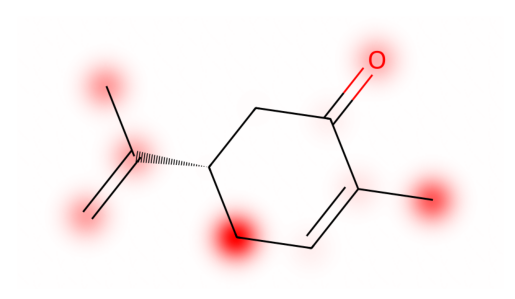

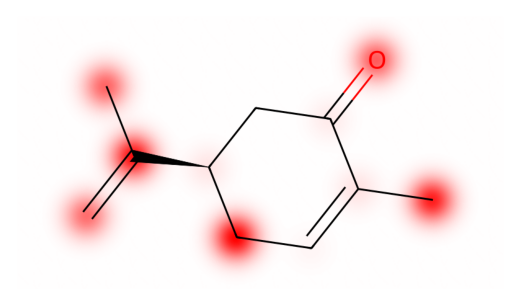

In [65]:
from rdkit import Chem
import torch
max_value = max(espam_s_carvone.max(), espam_r_carvone.max())   
min_value = min(espam_s_carvone.min(), espam_r_carvone.min())
def add_dummy_atoms(smiles, espam_values, min_value, max_value):
    mol = Chem.MolFromSmiles(smiles)
    dummy1 = Chem.Atom(0)  # Atomic number 0 for dummy atom
    dummy2 = Chem.Atom(0)
    idx1 = rw_mol.AddAtom(dummy1)
    idx2 = rw_mol.AddAtom(dummy2)
    rw_mol = Chem.RWMol(mol)
    
    # Add two dummy atoms

    
    # Add bonds to separate the dummy atoms from the main molecule
    #rw_mol.AddBond(0, idx1, Chem.BondType.SINGLE)
    #rw_mol.AddBond(0, idx2, Chem.BondType.SINGLE)
    
    # Update the espam values
    espam_values = torch.cat([espam_values, torch.tensor([min_value, max_value])])
    
    return Chem.MolToSmiles(rw_mol), espam_values

# Update the molecules and espam values
#s_carvone, espam_s_carvone = add_dummy_atoms(s_carvone, espam_s_carvone, min_value, max_value)
#r_carvone, espam_r_carvone = add_dummy_atoms(r_carvone, espam_r_carvone, min_value, max_value)

draw_molecule_with_espam(s_carvone, (espam_s_carvone-min_value)/(max_value - min_value))#, 0, 1)
draw_molecule_with_espam(r_carvone, (espam_r_carvone-min_value)/(max_value - min_value))#, 0, 1)

## Run ESPAM for Quantitavie Results 


In [21]:
from ESPAM.loaders import load_and_process_data_for_protein, save_to_pkl
#from ESPAM.mitihelper import compute_model_score
import ESPAM.mitihelper as mh
from importlib import reload
import ESPAM.loaders as ff
import ESPAM.ESPAMS as es
from ESPAM.utils import from_smiles_to_data
from sme.MaskGNN_interpretation.build_data import build_mol_graph_data_for_murcko
from sme.MaskGNN_interpretation.build_data import build_mol_graph_data_for_fg
reload(es)
reload(ff)
reload(mh)
#from mh import compute_model_score
from tqdm import tqdm 
bert_func = generate_cls()
#cls_dict = {}
#seq_map = pd.read_csv("GNN_Transformer/seqs.csv", delimiter=";")
for protein in ["OR1A1", "OR7D4", "OR51E2", "OR5K1"]:
#data = ff.load_and_process_data_for_protein(uni_protid, data_file_name="GNN_Transformer/data_train_node32_edge64.csv", seq_file="GNN_Transformer/seqs.csv",
                                      #mol_file="mols.csv")
    data = pd.read_excel(f"OR_data_for_ESPAM/{protein}_pairs_all.xlsx")
    acc = 0 
    cnt = 0
    for method in ["atom"]:
        for l in [4] if protein == "OR1A1" else [2]:
            res = {}
            for i, row in tqdm(data.iterrows()):
                #try:
                #    predicted_class = mh.compute_model_score(row['SMILES'], seq, model)[0].argmax().item()
                #except:
                #    continue

          
                seq = row["Sequence"]
                try:
                    seq_id = seq_map.loc[seq_map["mutated_Sequence"] == seq]['seq_id'].head(1).item()
                except:
                    print(seq_map.loc[seq_map["mutated_Sequence"] == seq]['seq_id'].head(2))
                    print(seq)
                    print(len(seq_map["mutated_Sequence"][288]))
                    for ll in range(len(seq)):
                        if seq[ll] != seq_map["mutated_Sequence"][288][ll]:
                            print(ll)
                            print(seq[ll])
                            print(seq_map["mutated_Sequence"][288][ll])
                    raise
                #print(seq_id)
                #if seq not in cls_dict.keys():
                #    cls_dict[seq] = bert_func(seq).reshape(1, -1)
                #seq_cls = cls_dict[seq]#becomes CLS token
                seq_cls = bert_func(seq_id)
                try:
                    dataa = from_smiles_to_data(row['SMILES'])
                    predicted_class = mh.compute_model_score(row['SMILES'], seq_cls, model)[0].argmax().item()
                    #cnt += 1
                    #if predicted_class == 1 - row["Responsive"]:
                    #    acc += 1
                    t = es.espam_ego_networks_average(dataa, seq_cls, model, predicted_class, l=l)
                    if row['SMILES'] in res.keys():
                        res[row['SMILES']][seq_id] = {"ESPAM": t,"predicted_class": predicted_class}
                    else:
                        res[row['SMILES']] = {seq_id: {"ESPAM": t,"predicted_class": predicted_class}}
                #res.append({"SMILES": row['SMILES'], "ESPAM": t,"predicted_class": predicted_class, "sequence id": seq_id})
                except:
                    continue
            save_to_pkl(res, f"ESPAM_{method}_{protein}_{l}_nice.pkl")
            #print(f"protein: {protein} acc: {acc/cnt}")



## Dataset Info

In [ ]:
from ESPAM.loaders import load_and_process_data_for_protein, save_to_pkl
#from ESPAM.mitihelper import compute_model_score
import ESPAM.mitihelper as mh
from importlib import reload
import ESPAM.loaders as ff
import ESPAM.ESPAMS as es
from ESPAM.utils import from_smiles_to_data
from sme.MaskGNN_interpretation.build_data import build_mol_graph_data_for_murcko
from sme.MaskGNN_interpretation.build_data import build_mol_graph_data_for_fg
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

reload(es)
reload(ff)
reload(mh)
seq_map = pd.read_csv("GNN_Transformer/seqs.csv", delimiter=";")
bert_func = generate_cls()
from tqdm import tqdm
for protein in ["OR51E2"]:
    data = pd.read_excel(f"OR_data_for_ESPAM/{protein}_pairs_all.xlsx")
    acc = 0 
    cnt = 0
    res = {}
    probabilities_list = []
    labels = []
    predictions = []
    for i, row in tqdm(data.iterrows()):
        seq = row["Sequence"]
        seq_id = seq_map.loc[seq_map["mutated_Sequence"] == seq]['seq_id'].head(1).item()
        seq_cls = bert_func(seq_id)
        try:
            dataa = from_smiles_to_data(row['SMILES'])
            predicted_class = mh.compute_model_score(row['SMILES'], seq_cls, model)[0].argmax().item()
            target_class = mh.compute_model_score(dataa, seq_cls, model)[0].argmax().item()
            probabilities = np.array(mh.compute_model_score(dataa, seq_cls, model)[0].tolist())
            label = 1 - row["Responsive"]

        except Exception as e:
            print(e)
            continue
        predictions.append(target_class)
        probabilities_list.append(probabilities[0]) 
        labels.append(label)
    f1_pos = f1_score(labels, predictions, pos_label=1)
    roc_auc = roc_auc_score(1-np.array(labels), probabilities_list)
    pr_auc = average_precision_score(1-np.array(labels), probabilities_list)

    print(f" {f1_pos=}& {roc_auc=}& {pr_auc=}")

In [6]:
from ESPAM.loaders import load_and_process_data_for_protein, save_to_pkl
#from ESPAM.mitihelper import compute_model_score
import ESPAM.mitihelper as mh
from importlib import reload
import ESPAM.loaders as ff
import ESPAM.ESPAMS as es
from ESPAM.utils import from_smiles_to_data
from sme.MaskGNN_interpretation.build_data import build_mol_graph_data_for_murcko
from sme.MaskGNN_interpretation.build_data import build_mol_graph_data_for_fg
from tqdm import tqdm 
seq_map = pd.read_csv("GNN_Transformer/seqs.csv", delimiter=";")
bert_func = generate_cls()
for protein in ["OR1A1", "OR7D4", "OR51E2", "OR5K1"]:
    data = pd.read_excel(f"OR_data_for_ESPAM/{protein}_pairs_all.xlsx")
    acc = 0 
    cnt = 0
    for i, row in tqdm(data.iterrows()):
        true_label = row["Responsive"]
        seq = row["Sequence"]
        seq_id = seq_map.loc[seq_map["mutated_Sequence"] == seq]['seq_id'].head(1).item()
        #seq_cls = cls_dict[seq]#becomes CLS token
        seq_cls = bert_func(seq_id)
        try:
            dataa = from_smiles_to_data(row['SMILES'])
            predicted_class = mh.compute_model_score(row['SMILES'], seq_cls, model)[0].argmax().item()
            #print(predicted_class)
            #print(true_label)
            cnt += 1
            acc += int(predicted_class != true_label)
        except:
            pass
    acc/=cnt
    print(f"{protein=} {acc=}")

### API functions for ESPAM


In [141]:
import pickle
from rdkit import Chem
from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png
from rdkit.Chem import Draw
from rdkit import Chem
import numpy as np

import torch

def load_ESPAM_data_for_receptor(receptor_name, l=3):
    """
        This function loads the ESPAM data for a given receptor
    """
    
    with open(f"ESPAM_atom_{receptor_name}_{l}_nice.pkl", "rb") as file:
        res = pickle.load(file)
    #res ={smile: {seq: {"ESPAM": torch.tensor(data['ESPAM']), 'predicted_class': data['predicted_class']} for seq, data in value.items()} for smile, value in res.items()}
    return res


def get_smiles_list(ESPAM_data):
    """
        This function returns a list of smiles included in the ESPAM data which is loaded by load_ESPAM_data_for_receptor
    """
    return list(ESPAM_data.keys())


def draw_molecule(smiles, espam, save_name):
    """
        This function takes a SMILES and espam values and a save name to draw the heat map. 
        Please use the visualize function for drawing the heat maps
    """
    mol = Chem.MolFromSmiles(smiles)  
    test_mol = Draw.PrepareMolForDrawing(mol)
    heat_map = np.zeros(test_mol.GetNumAtoms())
    for key, value in enumerate(espam):
        heat_map[key] = value
    canvas = mapvalues2mol(test_mol, heat_map)
    img = transform2png(canvas.GetDrawingText())
    img.save(save_name)
    

def visualize(smiles, seq_id, ESPAM_data, save_name = None):
    """
        This function takes SMILES, sequence id, ESPAM data, and an optional parameter of the save_name
        If there is no error, the function draws the heat map and ends with the message:
        "Figure saved under the name {save_name}.png" where save name is {smiles}_{seq_id} if no name is given, otherwise the given name
    """
    if save_name is None:
        save_name = f"{smiles}_{seq_id}"
    assert smiles in ESPAM_data.keys(), "SMILES not found."
    assert seq_id in ESPAM_data[smiles].keys(), "There is no such sequence for this molecule."
    try:
        draw_molecule(smiles, ESPAM_data[smiles][seq_id]["ESPAM"], f"{save_name}.png")
    except:
        print("There was an error. Drawing was not successfull.")
        raise
    print(f"Figure saved under the name {save_name}.png")
    
    
def get_model_decision(smiles, seq_id, ESPAM_data):
    """
        Returns model decision for a SMILES and a sequence id.
    """
    
    assert smiles in ESPAM_data.keys(), "SMILES not found."
    assert seq_id in ESPAM_data[smiles].keys(), "There is no such sequence for this molecule."
    return 1 - ESPAM_data[smiles][seq_id]["predicted_class"]


def get_sequences_for_smiles(smiles, ESPAM_data):
    """
        Returns the list of the sequence ids that had interaction with the given smiles.
    """
    
    assert smiles in ESPAM_data.keys(), "SMILES not found."
    return list(ESPAM_data[smiles].keys())


def get_ESPAM_values(smiles, seq_id, ESPAM_data):
    """
        Return a list of tuples in which the first component is the atom name and the second component is its ESPAM value
        Parameters are SMILES, sequence id and ESPAM_data
        
    """
    
    assert smiles in ESPAM_data.keys(), "SMILES not found."
    assert seq_id in ESPAM_data[smiles].keys(), "There is no such sequence for this molecule."
    mol = Chem.MolFromSmiles(smiles)
    return list(zip(list(map(lambda x: x.GetSymbol(), mol.GetAtoms())), ESPAM_data[smiles][seq_id]["ESPAM"]))


"""
    Example: 
        1. First ESPAM data for 'OR1A1' is loaded into the variable test
        2. Then the list of the smiles is loaded to the variable smiles_list
        3. Then the list of sequences that had interaction with 'CCC(=O)C1=NCCC1' is loaded into the variable sequences_for_the_smiles
        4. Then the ESPAM values for the interaction between 'CCC(=O)C1=NCCC1' and 's_29' is loaded into the variable ESPAM_values
        5. Finally the heat map of the ESPAM for the mentioned interaction is visaulised in the last line

#Uncomment the following lines to see the example.

test = load_ESPAM_data_for_receptor('OR1A1')
smiles_list = get_smiles_list(test)
sequences_for_the_smiles = get_sequences_for_smiles('CCC(=O)C1=NCCC1', test)
ESPAM_values = get_ESPAM_values('CCC(=O)C1=NCCC1', 's_29', test)
visualize('CCC(=O)C1=NCCC1', 's_29', test)
"""


"\n    Example: \n        1. First ESPAM data for 'OR1A1' is loaded into the variable test\n        2. Then the list of the smiles is loaded to the variable smiles_list\n        3. Then the list of sequences that had interaction with 'CCC(=O)C1=NCCC1' is loaded into the variable sequences_for_the_smiles\n        4. Then the ESPAM values for the interaction between 'CCC(=O)C1=NCCC1' and 's_29' is loaded into the variable ESPAM_values\n        5. Finally the heat map of the ESPAM for the mentioned interaction is visaulised in the last line\n\n#Uncomment the following lines to see the example.\n\ntest = load_ESPAM_data_for_receptor('OR1A1')\nsmiles_list = get_smiles_list(test)\nsequences_for_the_smiles = get_sequences_for_smiles('CCC(=O)C1=NCCC1', test)\nESPAM_values = get_ESPAM_values('CCC(=O)C1=NCCC1', 's_29', test)\nvisualize('CCC(=O)C1=NCCC1', 's_29', test)\n"

### GStarX Baseline


In [6]:
from GStarX.gstarx import GStarX
from ESPAM.mitihelper import compute_model_score, from_smiles_to_data
import json
from more_itertools import set_partitions
from importlib import reload
import ESPAM.mitihelper as mi
reload(mi)
from tqdm import tqdm

def gstarx_model_function(seq_id, model, cls_dict=None):             
    seq = bert_func(seq_id) if cls_dict is None else cls_dict[seq_id]
    def model_output(data):
        x = mi.compute_model_score(data.cpu(), seq, model)
        if isinstance(x, int):
            return torch.tensor([[0, 1]]).cuda()
        return torch.tensor(x.tolist()).cuda()
    return model_output

device = "cuda:0"
gstar_dict = {}
for protein in ["OR1A1", "OR5K1", "OR7D4", "OR51E2"]:
    gstar_dict[protein] = {}
    espam_data = load_ESPAM_data_for_receptor(protein,l=16)
    smiles_list = get_smiles_list(espam_data)
    for smiles in tqdm(smiles_list):
        data = from_smiles_to_data(smiles).cuda()
        data.num_nodes = data.x.shape[0]
        seq_ids = get_sequences_for_smiles(smiles, espam_data)
        for seq_id in seq_ids: 
            gstarx_model = gstarx_model_function(seq_id, model)
            gstarxexplainer = GStarX(gstarx_model, device, payoff_type="raw")
            gstar_dict[(smiles, seq_id)] = gstarxexplainer.explain(data)
with open(f"GSTARX_res.pkl", "wb") as file:
    pickle.dump(gstar_dict, file)

In [ ]:
def get_char_func(mmodel, target_class, payoff_type="norm_prob", payoff_avg=None):
    def char_func(data):
        with torch.no_grad():
            logits = mmodel(data=data)
            if payoff_type == "raw":
                payoff = logits[:, target_class]
            elif payoff_type == "prob":
                payoff = logits.softmax(dim=-1)[:, target_class]
            elif payoff_type == "norm_prob":
                prob = logits.softmax(dim=-1)[:, target_class]
                payoff = prob - payoff_avg[target_class]
            elif payoff_type == "log_prob":
                payoff = logits.log_softmax(dim=-1)[:, target_class]
            else:
                raise ValueError("unknown payoff type")
        return payoff

    return char_func
for key, value in gstar_dict.items():
    if isinstance(key, str):
        continue
    smiles, seq_id = key
    gstarx_model = gstarx_model_function(seq_id, model)
    data = from_smiles_to_data(smiles)
    target_class = gstarx_model(data).argmax(-1).item()
    print(target_class)
    charf = get_char_func(gstarx_model, target_class, payoff_type="raw", payoff_avg=None)
    print(gstarx_model(data))
    print(charf(data))
    print(value)

In [110]:
from torch_geometric.data import Data

def creat_mask_mol_data(smiles, mask):
    #mol = Chem.MolFromSmiles(smiles)
    #rwmol = Chem.RWMol(mol)
    #dummy_atom = Chem.MolFromSmiles('[*]')
    #dummy = dummy_atom.GetAtomWithIdx(0)
    #for i, flag in enumerate(mask.tolist()):
    #    if not flag:
    #        rwmol.ReplaceAtom(i, dummy)
    #return from_smiles_to_data(Chem.MolToSmiles(rwmol))
    data = from_smiles_to_data(smiles)
    mask = mask.to(bool)
    mask = ~mask
    while torch.any(mask):
        one_hop = (~mask[data.edge_index[0]]) | (~mask[data.edge_index[1]])
        one_hop = torch.concat((data.edge_index[0, one_hop], data.edge_index[1, one_hop]))
        #print(one_hop)
        mask = torch.ones_like(mask)
        mask[one_hop] = 0
        mask = mask.to(bool)
        x = data.x.clone()
        edge_index = data.edge_index.clone()
        edge_attr = data.edge_attr.clone()
        for i, flag in enumerate(mask.tolist()):
            if not flag:
                x[i] = torch.zeros_like(x[i])
                #for j, edge in enumerate(data.edge_index):
                #    if i in edge:
                #        data.edge_attr[j] = torch.zeros_like(data.edge_attr[j])
        edge_mask = mask[edge_index[0]]&mask[edge_index[1]]
        edge_index = edge_index[:, edge_mask]
        edge_attr = edge_attr[edge_mask, :]
        #print(data.x)
        #print(data.edge_index)
        res = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        yield res

In [ ]:
import torch
def InFidelity(smiles, seq, model, attributions, masks):
    """
        smiles: The smiels representation of the input molecule
        seq: bert output of the sequence
        model: the explained model
        attributions: the attributions for the input molecule
        masks: the binary masks on the atoms of the input molecule
    """
    target_class = compute_model_score(smiles, seq, model)[0].argmax().item()
    res = 0
    total_attr = sum(attributions)
    model_decision = compute_model_score(smiles, seq, model, target_class)
    score = torch.zeros(masks.shape[0])
    for i, mask in enumerate(masks):
        cnt = 0
        for masked_smiles in creat_mask_mol_data(smiles, mask):
            masked_model_prob = compute_model_score(masked_smiles, seq, model, target_class)
        #score1 = (int((torch.dot(mask, torch.tensor(attributions))/total_attr) < 0.5) - int((masked_model_prob/model_decision)<0.5))**2
        #score1 = (torch.dot(mask, torch.tensor(attributions))/total_attr - masked_model_prob/model_decision)**2
            score[i]  += masked_model_prob/model_decision
            cnt += 1
        #mask_complement = 1 - mask
        #complement_masked_smiles = creat_mask_mol_data(smiles, mask_complement)
        #complement_masked_model_prob = compute_model_score(complement_masked_smiles, seq, model, target_class)
        #score2 = (int((torch.dot(mask, torch.tensor(attributions))/total_attr) < 0.5) - int((masked_model_prob/model_decision)<0.5))**2
        #score2 = 0 
        #res += (score1 + score2)/2
    #res/=masks.shape[0]
        score[i] /= cnt
    cos = torch.nn.CosineSimilarity(dim=0)
    #print(score.shape)
    #print((torch.tensor(attributions)/total_attr).shape)
    #print(score)
    #print(torch.tensor(attributions)/total_attr)
    res = cos(score, torch.tensor(attributions)/total_attr)
    return res

def generate_masks(dims):
    a = torch.ones(dims)/2
    random_masks = torch.bernoulli(a)
    return random_masks

for protein in ["OR5K1", "OR1A1", "OR7D4", "OR51E2"]:
    espam_data = load_ESPAM_data_for_receptor(protein)
    smiles_list = get_smiles_list(espam_data)
    gstar_res = 0
    espam_res = 0
    random_res = 0
    constant_res = 0
    shap_res = 0
    cnt = 0
    for smiles in tqdm(smiles_list):
        data = from_smiles_to_data(smiles)
        data.num_nodes = data.x.shape[0]
        dims = (data.num_nodes, data.num_nodes)
        seq_ids = get_sequences_for_smiles(smiles, espam_data)
        for seq_id in seq_ids: 
            seq = bert_func([seq_id])
            target_class = compute_model_score(smiles, seq, model)[0].argmax().item()
            #masks = generate_masks(dims)
            masks = torch.nn.functional.one_hot(torch.arange(data.x.shape[0]))
            espams = get_ESPAM_values(smiles, seq_id, espam_data)
            gstarx_values = gstar_dict[(smiles, seq_id)]
            shap_values = shap_dict[(smiles, seq_id)][0]
            random_vector = torch.empty(data.num_nodes).uniform_(0, 1)
            constant_vector = torch.ones(data.num_nodes)
            #print(constant_vector)
            espam_res += InFidelity(smiles, seq, model, list(map(lambda x: x[1], espams)), masks)
            gstar_res += InFidelity(smiles, seq, model, gstarx_values, masks)
            random_res += InFidelity(smiles, seq, model, random_vector, masks)
            constant_res += InFidelity(smiles, seq, model, constant_vector, masks)
            shap_res += InFidelity(smiles, seq, model, shap_values, masks)
            
            cnt+= 1
    print(f"protein: {protein}\t espam infid: {espam_res/cnt}\t gstar infid: {gstar_res/cnt}\t shap infid: {shap_res/cnt} \t random infid: {random_res/cnt}, constant infid: {constant_res/cnt}")

### SHAP Baseline


In [11]:
def shap_model_function(smiles, seq_id, model, cls_dict=None):
    if cls_dict is None:
        seq = bert_func(seq_id)
    else:
        seq = cls_dict[seq_id]
    target_class = compute_model_score(smiles, seq, model)[0].argmax().item() 
    def output_model(mask):
        #print(mask[0])

        masked_input = creat_mask_mol_data(smiles, mask[0])
        res = torch.tensor(compute_model_score(masked_input, seq, model, target_class))
        #print(res)
        return res
    return output_model
        

In [ ]:
from captum.attr import *

In [16]:
from captum.attr._core.kernel_shap import KernelShap
from tqdm import tqdm 
from ESPAM.mitihelper import from_smiles_to_data, compute_model_score
device = "cpu"
shap_dict = {}
for protein in ["OR1A1", "OR5K1", "OR7D4", "OR51E2"]:
    espam_data = load_ESPAM_data_for_receptor(protein, l=3)
    smiles_list = get_smiles_list(espam_data)
    for smiles in tqdm(smiles_list):
        data = from_smiles_to_data(smiles)
        data.num_nodes = data.x.shape[0]
        seq_ids = get_sequences_for_smiles(smiles, espam_data)
        for seq_id in seq_ids: 
            shap_model = shap_model_function(smiles, seq_id, model)
            shap = KernelShap(shap_model)
            attr = shap.attribute(torch.tensor([[1]*from_smiles_to_data(smiles).x.shape[0]]))
            shap_dict[(smiles, seq_id)] = attr
with open(f"shap_dict", "wb") as file:
    pickle.dump(shap_dict, file)

### ESPAM 

In [22]:
import captum
from tqdm import tqdm 
from ESPAM.mitihelper import from_smiles_to_data, compute_model_score
device = "cpu"
shap_dict = {}

for protein in ["OR1A1", "OR5K1", "OR7D4", "OR51E2"]:
    l=4 if protein == "OR1A1" else 2
    espam_data = load_ESPAM_data_for_receptor(protein)
    smiles_list = get_smiles_list(espam_data)
    for smiles in tqdm(smiles_list):
        data = from_smiles_to_data(smiles)
        data.num_nodes = data.x.shape[0]
        seq_ids = get_sequences_for_smiles(smiles, espam_data)
        for seq_id in seq_ids:  
            seq = bert_func(seq_id)
            target_class = compute_model_score(smiles, seq, model)[0].argmax().item() 
            es.espam_ego_networks_average(data, seq, model, target_class, l=l)


### Metric computation

In [ ]:
import ESPAM.evaltools as evaltools
from importlib import reload
reload(evaltools)
from ESPAM.mitihelper import from_smiles_to_data, compute_model_score
from torch_geometric.data import Data
from tqdm import tqdm
import numpy as np


def creat_mask_mol_data(smiles, mask, inv=True):
    #mol = Chem.MolFromSmiles(smiles)
    #rwmol = Chem.RWMol(mol)
    #dummy_atom = Chem.MolFromSmiles('[*]')
    #dummy = dummy_atom.GetAtomWithIdx(0)
    #for i, flag in enumerate(mask.tolist()):
    #    if not flag:
    #        rwmol.ReplaceAtom(i, dummy)
    #return from_smiles_to_data(Chem.MolToSmiles(rwmol))
    
    
    data = from_smiles_to_data(smiles)
    mask = mask.to(bool)
    #mask = ~mask
    #while torch.any(mask):
    #one_hop = (~mask[data.edge_index[0]]) | (~mask[data.edge_index[1]])
    #one_hop = torch.concat((data.edge_index[0, one_hop], data.edge_index[1, one_hop]))
    #print(one_hop)
    #mask = torch.ones_like(mask)
    #mask[one_hop] = 0
    #mask = mask.to(bool)
    x = data.x.clone()
    edge_index = data.edge_index.clone()
    edge_attr = data.edge_attr.clone()
    if inv:
        #for i, flag in enumerate(mask.tolist()):
            #if not flag:
                #x[i] = torch.zeros_like(x[i])
                #for j, edge in enumerate(data.edge_index):
                #    if i in edge:
                #        data.edge_attr[j] = torch.zeros_like(data.edge_attr[j])
        x[~mask] = torch.zeros_like(x[~mask])
    else:
        x = x[mask]
    edge_mask = mask[edge_index[0]]&mask[edge_index[1]]
    if inv:
        edge_attr[~edge_mask] = torch.zeros_like(edge_attr[~edge_mask])
        edge_index = edge_index[:, edge_mask]
        edge_attr = edge_attr[edge_mask]

    else:
        edge_index = edge_index[:, edge_mask]#TODO Rename the nodes
        edge_attr = edge_attr[edge_mask]
    #print(data.x)
    #print(data.edge_index)
    res = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, true_edges=sum(edge_mask))
    #print(mask.sum(), edge_index.shape, ed)
    return res


def one_hope_mask(smiles, mask, k=1):
    data = from_smiles_to_data(smiles)
    mask = mask.to(bool)
    #while torch.any(mask):
    for i in range(k):
        mask = ~mask
        one_hop = (~mask[data.edge_index[0]]) | (~mask[data.edge_index[1]])
        one_hop = torch.concat((data.edge_index[0, one_hop], data.edge_index[1, one_hop]))
        #print(one_hop)
        mask = torch.ones_like(mask)
        mask[one_hop] = 0
        mask = ~mask.to(bool)
    #print(sum(mask), mask.shape[0])
    return mask

def top_k_percent_edge(smiles, values, k):
    data = from_smiles_to_data(smiles)
    values = torch.tensor(values)
    edge_index = data.edge_index
    node_mask = torch.zeros_like(values).bool()
    sorted_values, indices = torch.sort(values)
    cnt = indices.shape[0] - 1
    while cnt > 0:
        node_mask[indices[cnt]] = True
        edge_mask = node_mask[edge_index[0]] & node_mask[edge_index[1]]
        nb_edges = edge_mask.sum()
        if nb_edges > k*edge_index.shape[1]:
            break
        cnt -= 1
    #print(values)
    #print(node_mask)
    return node_mask


#####################
#####################
#####################
def select_three_best(smiles, values):
    best_value = -1000
    selected_indices = []
    data = from_smiles_to_data(smiles)
    adj_list = [[]for _ in range(data.x.shape[0])]
    #print(data.edge_index.T)
    for u, v in data.edge_index.T:
        adj_list[u].append(v)
    adj_list = list(map(lambda x: sorted(x, key= lambda y: values[y]), adj_list))
    for i, neighbors in enumerate(adj_list):
        if len(neighbors) < 2:
            continue
        if values[i] + values[neighbors[-1]] + values[neighbors[-2]] > best_value:
            best_value  = values[i] + values[neighbors[-1]] + values[neighbors[-2]]
            selected_indices = (i, neighbors[-1], neighbors[-2])
    mask = torch.zeros(data.x.shape[0])
    #print(torch.tensor(selected_indices))
    mask[torch.tensor(selected_indices, dtype=int)] = 1
    return mask.to(bool)

def select_four_best(smiles, values):
    best_value = -1000
    selected_indices = []
    data = from_smiles_to_data(smiles)
    adj_list = [[]for _ in range(data.x.shape[0])]
    values = torch.tensor(values)
    #print(data.edge_index.T)
    for u, v in data.edge_index.T:
        adj_list[u].append(v)
    adj_list = list(map(lambda x: sorted(x, key= lambda y: values[y]), adj_list))
    for i, neighbors in enumerate(adj_list):
        if len(neighbors) < 3:
            continue
        if values[i] + sum(values[[torch.tensor(neighbors[-3:])]]) > best_value:
            best_value  = values[i] + sum(values[[neighbors[-3:]]])
            selected_indices = (i, neighbors[-1], neighbors[-2], neighbors[-3])
    for i, neighbors in enumerate(adj_list):
        if len(neighbors) < 2:
            continue
        n_dict = {}
        best_path = ()
        best_path_value = -1000
        for child in neighbors:
            for second_child in adj_list[child][::-1]:
                if second_child not in neighbors: 
                    n_dict[child] = second_child
                    if best_path_value < values[child] + values[second_child] and child!= neighbors[-1]: 
                        best_path_value = values[child] + values[second_child]
                        best_path = (child, second_child)
                    break
        best_child = neighbors[-1]
        if best_value < values[i] + values[best_child] + values[n_dict[best_child]] + values[neighbors[-2]]:
            best_value = values[i] + values[best_child] + values[n_dict[best_child]] + values[neighbors[-2]]
            selected_indices = (i , best_child , n_dict[best_child] , neighbors[-2])
        if best_value < best_path_value + values[i] + values[best_child]:
            best_value = best_path_value + values[i] + values[best_child]
            selected_indices = (i , best_child , best_path[0], best_path[1])
    mask = torch.zeros(data.x.shape[0])
    #print(torch.tensor(selected_indices))
    mask[torch.tensor(selected_indices, dtype=int)] = 1
    return mask.to(bool)

#####################
#####################
#####################              

def mask_compute(smiles, seq, values,  model, target_class, mask_creator_function, min_sparsity):
    data = from_smiles_to_data(smiles)
    number_of_nodes = data.x.shape[0]
    best_hfid = -100
    best_mask = None
    fid_make_mask = lambda smiles, mask: creat_mask_mol_data(smiles, mask, inv=True)
    #print("_"*50)
    for i in range(1,number_of_nodes):
        mask = mask_creator_function(smiles, values, i)
        fid = evaltools.fidelity(smiles, seq, mask, model, target_class, fid_make_mask)
        infid = evaltools.infidelity(smiles, seq, mask, model, target_class, fid_make_mask)
        spars = 1 -i/number_of_nodes#evaltools.sparsity(smiles, mask, fid_make_mask)
        if spars < min_sparsity:
            break
        n_fid = fid*spars
        n_infid = infid*(1 - spars)
        hfid = ((1 + n_fid)*(1 - n_infid))/(2+ n_fid - n_infid)
        #print(hfid, fid, infid, spars)
        best_hfid = max(hfid, best_hfid)
    if best_hfid < 0:
        print(smiles, number_of_nodes, values)
        print(hfid, fid, infid, spars)
        #if hfid > best_hfid: 
        #    best_hfid, best_mask = hfid, mask
        #    best_fid, best_infid, best_spars = fid, infid, spars
    #print("_"*50)
    return best_hfid



def top_k_percent_nodes(values, k):
    values = torch.tensor(values)
    number_of_nodes = values.shape[0]
    sorted_values, indices = torch.sort(values, descending=True)
    #print(max(int(k*number_of_nodes/100), 1))
    #print(k)
    selected_indices = indices[:k]#:5]#int(k*number_of_nodes/100 +1)]
    mask = torch.zeros(number_of_nodes)
    mask[selected_indices] = 1
    #print(values)
    #print(mask)
    return mask.to(bool)
    
def add_to_metrics_dict(smiles, seq, values, mask_creator_function, model, target_class, method, protein):
    best_k = 1
    best_hfid = -100
    best_mask = None
    best_fid = best_infid = best_spars = None
    fid_make_mask = lambda smiles, mask: creat_mask_mol_data(smiles, mask, inv=True)
    number_of_edges = from_smiles_to_data(smiles).edge_index.shape[1]
    current_number_of_edges = -1 
    """for kk in range(10):
        k=kk/100
        #if int(k*number_of_edges) != current_number_of_edges:
        #    current_number_of_edges = int(k*number_of_edges)
        #else:
        #    continue
        mask = mask_creator_function(smiles, values, kk)
        fid = evaltools.fidelity(smiles, seq, mask, model, target_class, creat_mask_mol_data)
        infid = evaltools.infidelity(smiles, seq, mask, model, target_class, creat_mask_mol_data)
        spars = evaltools.sparsity(smiles, mask, fid_make_mask)
        #print(spars)
        n_fid = fid*spars
        n_infid = infid*(1 - spars)
        hfid = ((1 + n_fid)*(1 - n_infid))/(2+ n_fid - n_infid)
        if hfid > best_hfid: 
            best_hfid, best_k, best_mask = hfid, k, mask
            best_fid, best_infid, best_spars = fid, infid, spars"""
    best_hfid = mask_compute(smiles, seq, values, model, target_class, mask_creator_function, 0.5)
    hfidelity_dict[(protein, method)] += best_hfid
    hfid_val[(method, protein)].append(best_hfid)
    """fidelity_dict[(protein, method)] += best_fid
    infidelity_dict[(protein, method)] += best_infid
    sparsity_dict[(protein, method)] += best_spars"""
    #fidelity_acc_dict[(protein, method)] += evaltools.fidelity_acc(smiles, seq, best_mask, model, target_class, fid_make_mask)
    #infidelity_acc_dict[(protein, method)] += evaltools.infidelity_acc(smiles, seq, best_mask, model, target_class, creat_mask_mol_data)
    if (protein, method) not in k_dict.keys():
        k_dict[(protein, method)] = 0
    #k_dict[(protein, method)] += best_k    
    
    
def devide_metric_values(protein, method, cnt):
    fidelity_dict[(protein, method)] /= cnt
    infidelity_dict[(protein, method)] /= cnt
    fidelity_acc_dict[(protein, method)] /= cnt
    infidelity_acc_dict[(protein, method)] /= cnt
    sparsity_dict[(protein, method)] /= cnt  
    hfidelity_dict[(protein, method)] /= cnt
    k_dict[(protein, method)] /= cnt

fidelity_dict = {}
infidelity_dict = {}
fidelity_acc_dict = {}
infidelity_acc_dict = {}
hfidelity_dict = {}
sparsity_dict = {}
k_dict = {}
hfid_val = {(method, protein): [] for method in ["ESPAM", "shap", "gstarx", "random", "constant", "subgraphx"] for protein in ["OR5K1", "OR51E2", "OR1A1", "OR7D4"]}
hfid_val = {(method, protein): [] for method in ["ESPAM", "shap", "gstarx"] for protein in ["OR5K1", "OR51E2", "OR1A1", "OR7D4"]}
std_dict = {}

mask_func_espam = lambda smiles, values, k: one_hope_mask(smiles, top_k_percent_nodes(values, k))    
mask_func = lambda smiles, values, k: top_k_percent_nodes(values, k)   
#mask_func = lambda smiles, values, k: one_hope_mask(smiles, select_three_best(smiles, values), k)
#mask_func = lambda smiles, values, k: top_k_percent_edge(smiles, values, k)
for protein in ["OR5K1", "OR51E2", "OR1A1", "OR7D4"]:
    l = {"OR5K1": 2, "OR51E2": 2, "OR1A1": 4, "OR7D4": 2}[protein]
    espam_data = load_ESPAM_data_for_receptor(protein, l)
    smiles_list = get_smiles_list(espam_data)
    #fidelity_dict[(protein, "shap")] = fidelity_dict[(protein, "gstarx")] = fidelity_dict[(protein, "ESPAM")] = fidelity_dict[(protein, "random")] = fidelity_dict[(protein, "constant")] = 0
    #hfidelity_dict[(protein, "shap")] = hfidelity_dict[(protein, "gstarx")] = hfidelity_dict[(protein, "ESPAM")] = hfidelity_dict[(protein, "random")] = hfidelity_dict[(protein, "constant")] = 0
    #infidelity_dict[(protein, "shap")] = infidelity_dict[(protein, "gstarx")] = infidelity_dict[(protein, "ESPAM")] = infidelity_dict[(protein, "random")] = infidelity_dict[(protein, "constant")] = 0
    #sparsity_dict[(protein, "shap")] = sparsity_dict[(protein, "gstarx")] = sparsity_dict[(protein, "ESPAM")] = sparsity_dict[(protein, "random")] = sparsity_dict[(protein, "constant")] = 0
    #infidelity_acc_dict[(protein, "shap")] = infidelity_acc_dict[(protein, "gstarx")] = infidelity_acc_dict[(protein, "ESPAM")] = infidelity_acc_dict[(protein, "random")] = infidelity_acc_dict[(protein, "constant")] = 0
    for method in ["ESPAM", "shap", "gstarx"]:#, "random", "constant"]:
        fidelity_dict[(protein, method)] = 0
        hfidelity_dict[(protein, method)] = 0
        infidelity_dict[(protein, method)] = 0
        sparsity_dict[(protein, method)] = 0
        infidelity_acc_dict[(protein, method)] = 0
        fidelity_acc_dict[(protein, method)] = 0
        
        
    cnt = 0
    for smiles in tqdm(smiles_list):
        data = from_smiles_to_data(smiles)
        data.num_nodes = data.x.shape[0]
        seq_ids = get_sequences_for_smiles(smiles, espam_data)
        for seq_id in seq_ids: 
            seq = bert_func(seq_id)
            target_class = compute_model_score(smiles, seq, model)[0].argmax().item()
            espams = get_ESPAM_values(smiles, seq_id, espam_data)
            espams = list(map(lambda x: x[1], espams))
            add_to_metrics_dict(smiles, seq, espams, mask_func, model, target_class, "ESPAM", protein)
            if True or l==2:
                gstarx_values = gstar_dict[(smiles, seq_id)]
                add_to_metrics_dict(smiles, seq, gstarx_values, mask_func, model, target_class, "gstarx", protein)
                shap_values = shap_dict[(smiles, seq_id)][0]        
                add_to_metrics_dict(smiles, seq, shap_values, mask_func, model, target_class, "shap", protein)
            #random_vector = torch.empty(data.num_nodes).uniform_(0, 1)
            #add_to_metrics_dict(smiles, seq, random_vector, mask_func, model, target_class, "random", protein)
            #constant_vector = torch.ones(data.num_nodes)
            #add_to_metrics_dict(smiles, seq, constant_vector, mask_func, model, target_class, "constant", protein)
            cnt+= 1
    for method in ["ESPAM","shap", "gstarx", ]:#, "random", "constant"]:
        devide_metric_values(protein, method, cnt)
        std_dict[(protein, method)] = np.std(hfid_val[(method, protein)])
    #print(f"protein: {protein}\t espam hfid: {hfidelity_dict[(protein, 'ESPAM')]}\t gstar hfid: {hfidelity_dict[(protein, 'gstarx')]}\t shap hfid: {hfidelity_dict[(protein, 'shap')]} \t random hfid: {hfidelity_dict[(protein, 'random')]}, constant hfid: {hfidelity_dict[(protein, 'constant')]}")
    print(f"protein: {protein}\t espam hfid: {hfidelity_dict[(protein, 'ESPAM')]} ± {std_dict[(protein, 'ESPAM')]}\t gstar hfid: {hfidelity_dict[(protein, 'gstarx')]} ± {std_dict[(protein, 'gstarx')]}\t shap hfid: {hfidelity_dict[(protein, 'shap')]} ± {std_dict[(protein, 'shap')]}")
#for protein in ['OR5K1', 'OR1A1', 'OR7D4', 'OR51E2']:
#    print(f"protein: {protein}\t espam infid: {infidelity_dict[(protein, 'ESPAM')]}\t gstar infid: {infidelity_dict[(protein, 'gstarx')]}\t shap infid: {infidelity_dict[(protein, 'shap')]} \t random infid: {infidelity_dict[(protein, 'random')]}, constant infid: {infidelity_dict[(protein, 'constant')]}")
#for protein in ['OR5K1', 'OR1A1', 'OR7D4', 'OR51E2']:
#    print(f"protein: {protein}\t espam fid: {fidelity_dict[(protein, 'ESPAM')]}\t gstar fid: {fidelity_dict[(protein, 'gstarx')]}\t shap fid: {fidelity_dict[(protein, 'shap')]} \t random fid: {fidelity_dict[(protein, 'random')]}, constant fid: {fidelity_dict[(protein, 'constant')]}")
#for protein in ['OR5K1', 'OR1A1', 'OR7D4', 'OR51E2']:
#    print(f"protein: {protein}\t espam fid: {fidelity_acc_dict[(protein, 'ESPAM')]}\t gstar fid: {fidelity_acc_dict[(protein, 'gstarx')]}\t shap fid: {fidelity_acc_dict[(protein, 'shap')]} \t random fid: {fidelity_acc_dict[(protein, 'random')]}, constant fid: {fidelity_acc_dict[(protein, 'constant')]}")
#for protein in ['OR5K1', 'OR1A1', 'OR7D4', 'OR51E2']:
#    print(f"protein: {protein}\t espam infid: {infidelity_acc_dict[(protein, 'ESPAM')]}\t gstar infid: {infidelity_acc_dict[(protein, 'gstarx')]}\t shap infid: {infidelity_acc_dict[(protein, 'shap')]} \t random infid: {infidelity_acc_dict[(protein, 'random')]}, constant infid: {infidelity_acc_dict[(protein, 'constant')]}")    
#for protein in ['OR5K1', 'OR1A1', 'OR7D4', 'OR51E2']:
#    print(f"protein: {protein}\t espam spars: {sparsity_dict[(protein, 'ESPAM')]}\t gstar spars: {sparsity_dict[(protein, 'gstarx')]}\t shap spars: {sparsity_dict[(protein, 'shap')]} \t random spars: {sparsity_dict[(protein, 'random')]}, constant spars: {sparsity_dict[(protein, 'constant')]}")

In [277]:
import torch.nn as nn
from torch_geometric.data import Data

class Model(nn.Module):
    def __init__(self, model_to_explain, seq):
        super().__init__()
        self.model = model_to_explain
        self.seq = bert_func([seq])

    def forward(self, dgl_graph, feature_matrix):
        data = Data(x=feature_matrix, edge_index=torch.tensor((dgl_graph.edges()[0].tolist(),dgl_graph.edges()[1].tolist())), edge_attr=dgl_graph.edata['attr'])
        return torch.tensor(compute_model_score(data, seq, model).tolist())


## ESPAM on the Sequence Part


#### Functions to creat a cls table for the perturbated sequences.

In [ ]:
from ESPAM.loaders import load_and_process_data_for_protein, save_to_pkl
from ESPAM.mitihelper import compute_model_score
import ESPAM.mitihelper as mh
from importlib import reload
import ESPAM.loaders as ff
import ESPAM.ESPAMS as es
from ESPAM.utils import from_smiles_to_data
reload(es)
reload(ff)
reload(mh)

## Bert related functions

In [2]:
import pandas as pd

def load_mutated_sequences(seq_name):
    mutated_list = []
    df = pd.read_excel("mutation_effect.xlsx")
    df = df[df['Protein name'] == seq_name]
    if seq_name == '5ht2a_human':
        seq = seq_ht
    elif seq_name == 'adrb2_human':
        seq = seq_adrb
    mutated_list.append(seq)
    for index, row in df.iterrows():
        position = row['Position'] - 1  # Convert to 0-based index
        original, mutated = row['Mutation'].split('=>')
        original = original.strip()
        mutated = mutated.strip()
        if seq[position] == original:
            mutated_seq = seq[:position] + mutated + seq[position+1:]
            mutated_list.append(mutated_seq)
        else:
            print(seq[position], original, mutated)       
    return list(set(mutated_list))

def create_pertubation_dict(seqs, window_length=None):
    seq_list = []
    for seq in seqs: 
        seq_list.append(seq)
        seq_len = len(seq)
        if window_length is None:
            window_length = int(seq_len**0.5)
        for i in range(seq_len - window_length + 1):
            window = seq[i: i+window_length]
            positive_perturbation = seq[:i] + "[MASK]"*len(window) + seq[i+window_length:]
            negative_perturbation = "[MASK]"*len(seq[:i]) + window + "[MASK]"*len(seq[i+window_length:])
            seq_list.append(negative_perturbation)
            seq_list.append(positive_perturbation)
    seq_list = list(set(seq_list))
    return seq_list

def creat_seq_map(perturbated_seqs, protein_name):
    data = []
    for i, seq in enumerate(perturbated_seqs):
        data.append([f"seq_{i}", seq])
    df = pd.DataFrame(data, columns=["seq_id", "perturbated_seq"])
    df.to_csv(f"seq_map_{protein_name}.csv", index=False)
    return df

def precompute_cls(seq_df, name="", seq_col="perturbated_seq"):
    from GNN_Transformer.precompute import PrecomputeProtBERT_CLS
    import os 
    import jax 
    from transformers import BertTokenizer, BertConfig, FlaxBertModel
    jax.config.update("jax_platform_name", "cpu")

    tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
    config = BertConfig.from_pretrained("Rostlab/prot_bert", output_hidden_states=True, output_attentions=False)
    bert_model = FlaxBertModel.from_pretrained("Rostlab/prot_bert", from_pt = True, config = config)
    precomuteBERT_CLS = PrecomputeProtBERT_CLS(data_file = f"seq_map_{name}.csv",
                                    save_dir = os.path.join('BERT_GNN','Data','chemosimdb','mixOnly_20220621-145302'),
                                    mode = 'w',
                                    dbname = f'preturbated_seq_{name}.h5',
                                    id_col = 'seq_id',
                                    seq_col = seq_col,
                                    batch_size = 4,
                                    bert_model = bert_model,
                                    tokenizer = tokenizer,
                                    )
    def precompute_and_save(self, data):
            # data = self.load_data()

            data = data[[self.id_col, self.seq_col]]
            data = data[~data[self.id_col].duplicated()]
            print('Number of records to process:  {}'.format(len(data)))
            
            self.create_h5file(expectedrows = len(data))
            self._precompute_and_save(data)
            self.h5file.close()

            self.save_hparams()
            return None
    precompute_and_save(precomuteBERT_CLS, seq_df)


import tables
import pandas as pd 

def load_table(protein, return_table=True):
    cls_pert_dict = {}
    h5file = tables.open_file(f"BERT_GNN/Data/chemosimdb/mixOnly_20220621-145302/PrecomputeProtBERT_CLS/preturbated_seq_{protein}.h5", mode='r', title="TapeBERT")
    bert_table = h5file.root.bert.BERTtable
    if not return_table:
        for i, seq_id in enumerate(bert_table.col('id')):
            cls_pert_dict[seq_id.astype(str)] = bert_table.col('hidden_states')[i]
        h5file.close()
        return cls_pert_dict
    return bert_table

def load_cls_dict_perturbated(protein):
    cls_pert_dict = {}
    table = load_table(protein)
    seq_df = pd.read_csv(f"seq_map_{protein}.csv")
    for _, row in seq_df.iterrows():
        perturbated_sequence = row['perturbated_sequence']
        seq_id = row['id']
        cls_pert_dict[perturbated_sequence] = table[seq_id]
    return cls_pert_dict

def bert_func_seq(seq_name, preload=True, cls_dict=None, seq_map_name=None, seq_col="perturbated_seq"):
    if preload: 
        cls_dict = load_table(seq_name, return_table=False)
    else:
        cls_dict = load_table(seq_name, return_table=True)
    if seq_map_name is None:
        seq_map = pd.read_csv(f"seq_map_{seq_name}.csv")
    else:
        seq_map = pd.read_csv(seq_map_name, delimiter=";")
    def cls_fun(seq):
        try:
            seq_id = seq_map.loc[seq_map[seq_col] == seq, "seq_id"].values[0]
            if preload:
                return cls_dict[seq_id]
            hidden_status = cls_dict.col('hidden_states')[cls_dict.col('id').astype(str) == f"{seq_id}"]
            return hidden_status
        except:
            if not preload:
                seq_map.close()
            raise
    return cls_fun

def compute_bert_on_fly(seq):
    df = creat_seq_map([seq], "temp")
    precompute_cls(df, "temp")
    cls_dict = load_table("temp", return_table=False)
    return list(cls_dict.values())[0]

### Create the BERT Table

In [161]:
import pandas as pd
import numpy as np

def apply_mutations(sequence, mutations):
    for mutation in mutations.split('_'):
        C1 = mutation[0]
        pos = int(''.join(filter(str.isdigit, mutation))) - 1
        C2 = mutation[-1]
        if sequence[pos] == C1:
            sequence = sequence[:pos] + C2 + sequence[pos+1:]
        else:
            print(f"Warning: Expected {C1} at position {pos+1}, but found {sequence[pos]}")
    return sequence

def read_and_apply_mutations(csv_file, sequence):
    mutated_seqs = [sequence]
    df = pd.read_excel(csv_file)
    for mutation in df['Mutation']:
        if pd.notna(mutation) and mutation == "I205V":
            mutated_seqs.append(apply_mutations(sequence, mutation))
    mutated_seqs = list(set(mutated_seqs))
    return mutated_seqs

# Example usage
seq_name = "OR1A1_1"
csv_file = "OR_data_for_ESPAM/OR1A1_pairs_all.xlsx"
sequence = 'MRENNQSSTLEFILLGVTGQQEQEDFFYILFLFIYPITLIGNLLIVLAICSDVRLHNPMYFLLANLSLVDIFFSSVTIPKMLANHLLGSKSISFGGCLTQMYFMIALGNTDSYILAAMAYDRAVAISRPLHYTTIMSPRSCIWLIAGSWVIGNANALPHTLLTASLSFCGNQEVANFYCDITPLLKLSCSDIHFHVKMMYLGVGIFSVPLLCIIVSYIRVFSTVFQVPSTKGVLKAFSTCGSHLTVVSLYYGTVMGTYFRPLTNYSLKDAVITVMYTAVTPMLNPFIYSLRNRDMKAALRKLFNKRISS'
mutated_sequences= read_and_apply_mutations(csv_file, sequence)
perturbated_seqs = create_pertubation_dict(mutated_sequences, 4)
seq_map = seq_map = creat_seq_map(perturbated_seqs, seq_name)
precompute_cls(seq_map, seq_name)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing FlaxBertModel: {('cls', 'seq_relationship', 'kernel'), ('cls', 'predictions', 'transform', 'dense', 'kernel'), ('cls', 'predictions', 'transform', 'LayerNorm', 'kernel'), ('cls', 'predictions', 'decoder', 'bias'), ('cls', 'predictions', 'bias'), ('cls', 'predictions', 'transform', 'dense', 'bias'), ('cls', 'seq_relationship', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias'), ('cls', 'predictions', 'decoder', 'kernel')}
- This IS expected if you are initializing FlaxBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of records to process:  920


230it [18:55,  4.94s/it]

creating index...


In [4]:
sequence_wt = 'MRENNQSSTLEFILLGVTGQQEQEDFFYILFLFIYPITLIGNLLIVLAICSDVRLHNPMYFLLANLSLVDIFFSSVTIPKMLANHLLGSKSISFGGCLTQMYFMIALGNTDSYILAAMAYDRAVAISRPLHYTTIMSPRSCIWLIAGSWVIGNANALPHTLLTASLSFCGNQEVANFYCDITPLLKLSCSDIHFHVKMMYLGVGIFSVPLLCIIVSYIRVFSTVFQVPSTKGVLKAFSTCGSHLTVVSLYYGTVMGTYFRPLTNYSLKDAVITVMYTAVTPMLNPFIYSLRNRDMKAALRKLFNKRISS'
sequence_i250v = "MRENNQSSTLEFILLGVTGQQEQEDFFYILFLFIYPITLIGNLLIVLAICSDVRLHNPMYFLLANLSLVDIFFSSVTIPKMLANHLLGSKSISFGGCLTQMYFMIALGNTDSYILAAMAYDRAVAISRPLHYTTIMSPRSCIWLIAGSWVIGNANALPHTLLTASLSFCGNQEVANFYCDITPLLKLSCSDIHFHVKMMYLGVGVFSVPLLCIIVSYIRVFSTVFQVPSTKGVLKAFSTCGSHLTVVSLYYGTVMGTYFRPLTNYSLKDAVITVMYTAVTPMLNPFIYSLRNRDMKAALRKLFNKRISS"
#ESPAM_values_wt = ESPAM_seq(sequence_wt, bert_function)
#ESPAM_values_i250_v = ESPAM_seq(smiles, sequence_i250v, model, 0, bert_function)#(sequence_i250v, bert_function)


In [ ]:
seg_or1a1_wt = {
  "entryType": "UniProtKB reviewed (Swiss-Prot)",
  "primaryAccession": "Q9P1Q5",
  "features": [
    {
      "type": "Topological domain",
      "location": {
        "start": {
          "value": 1,
          "modifier": "EXACT"
        },
        "end": {
          "value": 25,
          "modifier": "EXACT"
        }
      },
      "description": "Extracellular",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Transmembrane",
      "location": {
        "start": {
          "value": 26,
          "modifier": "EXACT"
        },
        "end": {
          "value": 49,
          "modifier": "EXACT"
        }
      },
      "description": "Helical; Name=1",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Topological domain",
      "location": {
        "start": {
          "value": 50,
          "modifier": "EXACT"
        },
        "end": {
          "value": 57,
          "modifier": "EXACT"
        }
      },
      "description": "Cytoplasmic",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Transmembrane",
      "location": {
        "start": {
          "value": 58,
          "modifier": "EXACT"
        },
        "end": {
          "value": 79,
          "modifier": "EXACT"
        }
      },
      "description": "Helical; Name=2",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Topological domain",
      "location": {
        "start": {
          "value": 80,
          "modifier": "EXACT"
        },
        "end": {
          "value": 100,
          "modifier": "EXACT"
        }
      },
      "description": "Extracellular",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Transmembrane",
      "location": {
        "start": {
          "value": 101,
          "modifier": "EXACT"
        },
        "end": {
          "value": 120,
          "modifier": "EXACT"
        }
      },
      "description": "Helical; Name=3",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Topological domain",
      "location": {
        "start": {
          "value": 121,
          "modifier": "EXACT"
        },
        "end": {
          "value": 139,
          "modifier": "EXACT"
        }
      },
      "description": "Cytoplasmic",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Transmembrane",
      "location": {
        "start": {
          "value": 140,
          "modifier": "EXACT"
        },
        "end": {
          "value": 158,
          "modifier": "EXACT"
        }
      },
      "description": "Helical; Name=4",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Topological domain",
      "location": {
        "start": {
          "value": 159,
          "modifier": "EXACT"
        },
        "end": {
          "value": 195,
          "modifier": "EXACT"
        }
      },
      "description": "Extracellular",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Transmembrane",
      "location": {
        "start": {
          "value": 196,
          "modifier": "EXACT"
        },
        "end": {
          "value": 218,
          "modifier": "EXACT"
        }
      },
      "description": "Helical; Name=5",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Topological domain",
      "location": {
        "start": {
          "value": 219,
          "modifier": "EXACT"
        },
        "end": {
          "value": 235,
          "modifier": "EXACT"
        }
      },
      "description": "Cytoplasmic",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Transmembrane",
      "location": {
        "start": {
          "value": 236,
          "modifier": "EXACT"
        },
        "end": {
          "value": 258,
          "modifier": "EXACT"
        }
      },
      "description": "Helical; Name=6",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Topological domain",
      "location": {
        "start": {
          "value": 259,
          "modifier": "EXACT"
        },
        "end": {
          "value": 270,
          "modifier": "EXACT"
        }
      },
      "description": "Extracellular",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Transmembrane",
      "location": {
        "start": {
          "value": 271,
          "modifier": "EXACT"
        },
        "end": {
          "value": 290,
          "modifier": "EXACT"
        }
      },
      "description": "Helical; Name=7",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    },
    {
      "type": "Topological domain",
      "location": {
        "start": {
          "value": 291,
          "modifier": "EXACT"
        },
        "end": {
          "value": 309,
          "modifier": "EXACT"
        }
      },
      "description": "Cytoplasmic",
      "evidences": [
        {
          "evidenceCode": "ECO:0000255"
        }
      ]
    }
  ],
  "extraAttributes": {
    "uniParcId": "UPI000013E937"
  }
}

segment_info = []

for feature in seg_or1a1_wt['features']:
    start = feature['location']['start']['value']
    end = feature['location']['end']['value']
    segment_type = feature['description']
    segment_info.append((start-1, end, segment_type))

print(segment_info)

[(0, 25, 'Extracellular'), (25, 49, 'Helical; Name=1'), (49, 57, 'Cytoplasmic'), (57, 79, 'Helical; Name=2'), (79, 100, 'Extracellular'), (100, 120, 'Helical; Name=3'), (120, 139, 'Cytoplasmic'), (139, 158, 'Helical; Name=4'), (158, 195, 'Extracellular'), (195, 218, 'Helical; Name=5'), (218, 235, 'Cytoplasmic'), (235, 258, 'Helical; Name=6'), (258, 270, 'Extracellular'), (270, 290, 'Helical; Name=7'), (290, 309, 'Cytoplasmic')]


In [6]:
from ESPAM.ESPAMS import espam_ego_networks_average
from ESPAM.mitihelper import from_smiles_to_data, compute_model_score
from tqdm import tqdm
import torch
def ESPAM_interaction(smiles, seq, model, class_index, bert_func1, original_cls):
    data = from_smiles_to_data(smiles)
    #original_cls = bert_func1(seq)
    original_contrib = espam_ego_networks_average(data, original_cls, model, class_index, 4)
    original_prob = compute_model_score(data, original_cls, model, class_index)
    contribs = []
    complement_contribs = []
    """for i in tqdm(range(len(seq))):
      perturbated_seq = seq[:i] + "[MASK]" 
        if i != len(seq) - 1:
            perturbated_seq += seq[i+1:]"""
    for start, end, segment_type in segment_info:
        if "Helical" in segment_type:
            # Mask only the helical part
            perturbated_seq = "[MASK]"*len(seq[:start]) + seq[start:end] + "[MASK]"*len(seq[end:]) 
            perturbated_cls = bert_func1(perturbated_seq)
            complement_seq = seq[:start] + "[MASK]"*len(seq[start:end]) + seq[end:]
            complement_cls = bert_func1(complement_seq)
            perturbated_contrib = torch.sigmoid(original_contrib - espam_ego_networks_average(data, perturbated_cls, model, class_index, 4)).numpy()
            complement_contribs.append(perturbated_contrib)
            complement_contrib = torch.sigmoid(original_contrib - espam_ego_networks_average(data, complement_cls, model, class_index, 4)).numpy()
            contribs.append(complement_contrib)
            #perturbated_prob = compute_model_score(data, perturbated_cls, model, class_index)
            #contribs.append((original_contrib - perturbated_contrib)*original_contrib)
            #contribs.append((original_contrib - perturbated_contrib))
    
    complement_contribs = np.array(complement_contribs)
    contribs = np.array(contribs)
    w = (original_contrib.sigmoid().numpy() + complement_contribs.sum(axis=0))/(complement_contribs.sum(axis=0) + contribs.sum(axis=0))
    print(w)
    print(w.shape)
    total_contribs = w*contribs - (1 - w)*complement_contribs
    #total_contribs *= original_contrib.numpy()/total_contribs.sum(axis=0)
    return total_contribs

    return contribs

### Creat Bert Table for Helical Perturbation

In [166]:
seq_name = "OR1A1_hel"
csv_file = "OR_data_for_ESPAM/OR1A1_pairs_all.xlsx"
sequence = 'MRENNQSSTLEFILLGVTGQQEQEDFFYILFLFIYPITLIGNLLIVLAICSDVRLHNPMYFLLANLSLVDIFFSSVTIPKMLANHLLGSKSISFGGCLTQMYFMIALGNTDSYILAAMAYDRAVAISRPLHYTTIMSPRSCIWLIAGSWVIGNANALPHTLLTASLSFCGNQEVANFYCDITPLLKLSCSDIHFHVKMMYLGVGIFSVPLLCIIVSYIRVFSTVFQVPSTKGVLKAFSTCGSHLTVVSLYYGTVMGTYFRPLTNYSLKDAVITVMYTAVTPMLNPFIYSLRNRDMKAALRKLFNKRISS'
perturbated_seqs = []
for start, end, segment_type in segment_info:
    if "Helical" in segment_type:
        # Mask only the helical part
        masked_seq = sequence[:start] + "[MASK]" * (end - start) + sequence[end:]
        perturbated_seqs.append(masked_seq)
        
        # Mask all except the helical part
        masked_except_seq = "[MASK]" * start + sequence[start:end] + "[MASK]" * (len(sequence) - end)
        perturbated_seqs.append(masked_except_seq)
seq_map = seq_map = creat_seq_map(perturbated_seqs, seq_name)
precompute_cls(seq_map, seq_name)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing FlaxBertModel: {('cls', 'predictions', 'transform', 'dense', 'kernel'), ('cls', 'predictions', 'decoder', 'kernel'), ('cls', 'predictions', 'transform', 'dense', 'bias'), ('cls', 'seq_relationship', 'kernel'), ('cls', 'predictions', 'transform', 'LayerNorm', 'kernel'), ('cls', 'predictions', 'bias'), ('cls', 'predictions', 'decoder', 'bias'), ('cls', 'seq_relationship', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias')}
- This IS expected if you are initializing FlaxBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of records to process:  14


HDF5ExtError: HDF5 error back trace

  File "../../src/H5F.c", line 1427, in H5Fcreate
    unable to create file
  File "../../src/H5F.c", line 1230, in H5F_open
    unable to truncate a file which is already open

End of HDF5 error back trace

Unable to open/create file 'BERT_GNN/Data/chemosimdb/mixOnly_20220621-145302/PrecomputeProtBERT_CLS/preturbated_seq_OR1A1_hel.h5'

In [3]:
seq_name = "OR1A1_4"
csv_file = "OR_data_for_ESPAM/OR1A1_pairs_all.xlsx"
bert_function4 = bert_func_seq(seq_name, preload=False)

In [8]:
seq_name = "OR1A1_hel"
bert_func_hel = bert_func_seq(seq_name, preload=False)

[0.5787606  0.5763994  0.57633185 0.60388494 0.5723083  0.57158566
 0.57503986 0.57890594 0.5761889  0.58064455 0.5807456 ]
(11,)
[[0.9988918  0.00110823]]
Model decision for masked Helical; Name=1: 0
[[0.36174795 0.638252  ]]
Model decision for masked Helical; Name=2: 1
[[0.20538591 0.7946141 ]]
Model decision for masked Helical; Name=3: 1
[[0.9735162  0.02648377]]
Model decision for masked Helical; Name=4: 0
[[0.97075313 0.02924687]]
Model decision for masked Helical; Name=5: 0
[[1.9853031e-04 9.9980146e-01]]
Model decision for masked Helical; Name=6: 1
[[0.84159154 0.15840846]]
Model decision for masked Helical; Name=7: 0
5.7405977 (7, 11) (11,)


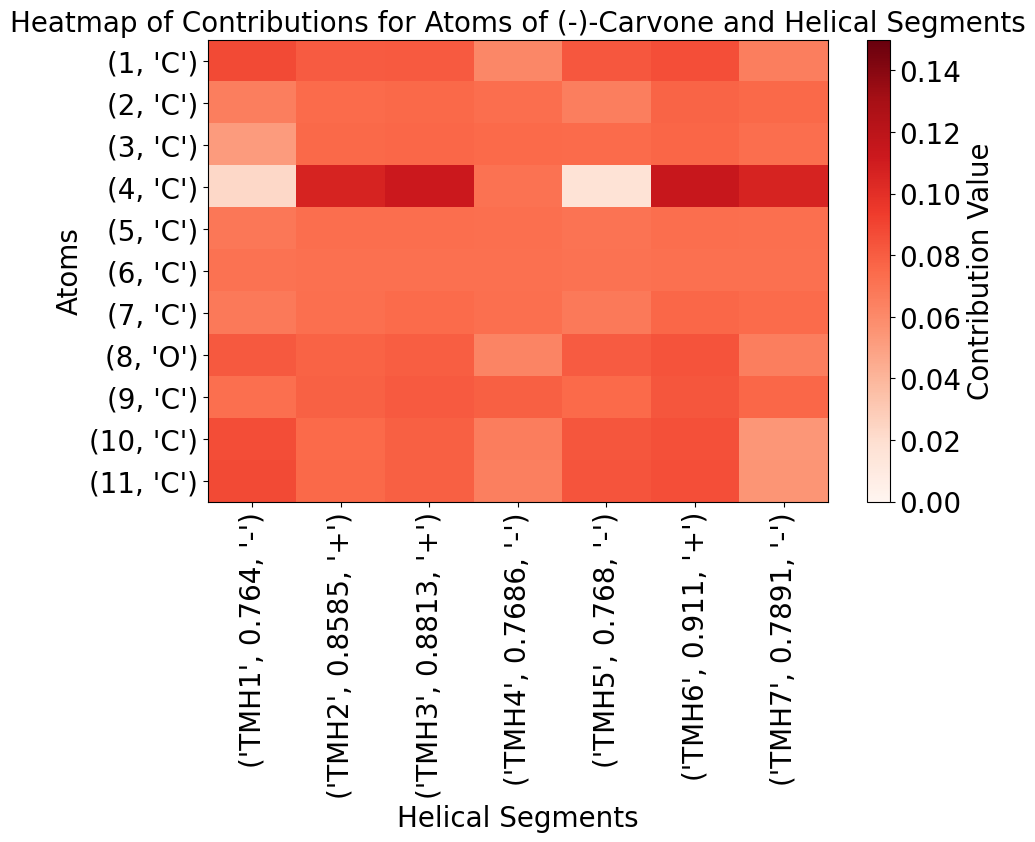

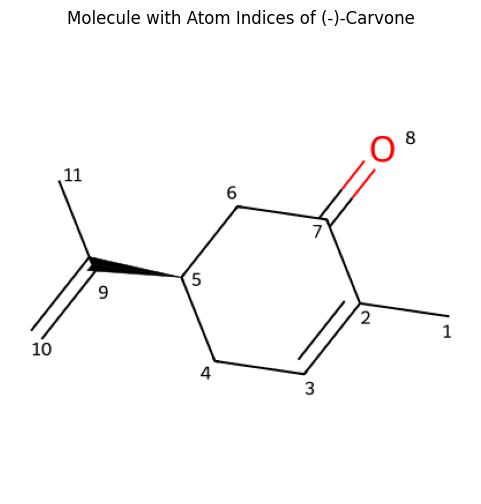

In [10]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

import matplotlib.pyplot as plt

def extract_atom_names(smiles):
    """Extract atom names from a SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    atom_names = [atom.GetSymbol() for atom in mol.GetAtoms()]
    return atom_names

def draw_heatmap(matrix, segment_info, atom_names, mole_name, masked_decision):
    """
    Draw a heatmap where each row corresponds to an atom and each column corresponds to a helical segment.
    
    Args:
        matrix (numpy.ndarray): n x m matrix where n is the sequence length and m is the number of atoms.
        segment_info (list): List of tuples (start, end, segment_type) for sequence segments.
        atom_names (list): List of atom names extracted from the SMILES string.
    """
    # Create a new matrix where each column corresponds to a helical segment
    segment_matrix = []
    segment_matrix = matrix
    segment_matrix_average = np.mean(matrix, axis=0)
    print(matrix.sum(), segment_matrix.shape, segment_matrix_average.shape)
    #for i in range(segment_matrix.shape[0]):
    #    segment_matrix[i]/= segment_matrix_average
    
    segment_labels = []
    for start, end, segment_type in segment_info:
        if "Helical" in segment_type:
            #segment_matrix.append(matrix[start:end].mean(axis=0))  # Average over the segment
            segment_labels.append(segment_type)
            #print(matrix[start:end,atom_names.index("O")].argsort()+1+start)
            #print(matrix[start:end,atom_names.index("O")].max())
    #segment_matrix = np.maximum(0, matrix)
    #segment_matrix /=  np.abs(matrix).max()
    segment_matrix = np.array(segment_matrix).T  # Transpose to make atoms as rows and segments as columns
    column_sums = np.sum(segment_matrix, axis=0)
    row_sums = np.sum(segment_matrix, axis=1)
    # Plot the heatmap

    # Calculate the sum of each column and row
    # Separate positive and negative values
    positive_matrix = np.maximum(0, segment_matrix)
    negative_matrix = np.minimum(0, segment_matrix)

    # Plot the heatmap for the positive values
    """plt.figure(figsize=(10, 6))
    plt.imshow(positive_matrix, cmap='viridis', aspect='auto', vmin=0)
    cbar = plt.colorbar(label='Positive Contribution Value')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label('Positive Contribution Value', size=20)

    # Set axis labels
    plt.yticks(ticks=np.arange(len(atom_names)), labels=enumerate(atom_names), fontsize=20)
    plt.xticks(ticks=np.arange(len(segment_labels)), labels=zip(list(map(lambda x: f"TMH{x+1}", range(len(segment_labels)))), list(map(lambda x: float(f"{x:.4f}"), column_sums)), list(map(lambda x: ["-", "+"][x], masked_decision))), rotation=90, fontsize=20)
    plt.xlabel('Helical Segments', fontsize=20)
    plt.ylabel('Atoms', fontsize=20)
    plt.title(f'Heatmap of Positive Contributions for Atoms of {mole_name} and Helical Segments', fontsize=20)
    plt.show()

    # Plot the heatmap for the negative values
    plt.figure(figsize=(10, 6))
    plt.imshow(negative_matrix, cmap='viridis_r', aspect='auto', vmax=0)
    cbar = plt.colorbar(label='Negative Contribution Value')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label('Negative Contribution Value', size=20)

    # Set axis labels
    plt.yticks(ticks=np.arange(len(atom_names)), labels=enumerate(atom_names), fontsize=20)
    plt.xticks(ticks=np.arange(len(segment_labels)), labels=zip(list(map(lambda x: f"TMH{x+1}", range(len(segment_labels)))), list(map(lambda x: float(f"{x:.4f}"), column_sums)), list(map(lambda x: ["-", "+"][x], masked_decision))), rotation=90, fontsize=20)
    plt.xlabel('Helical Segments', fontsize=20)
    plt.ylabel('Atoms', fontsize=20)
    plt.title(f'Heatmap of Negative Contributions for Atoms of {mole_name} and Helical Segments', fontsize=20)
    plt.show()"""

    plt.figure(figsize=(10, 6))
    plt.imshow(segment_matrix, cmap='Reds', aspect='auto', vmin=0, vmax=0.15)
    cbar = plt.colorbar(label='Contribution Value')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label('Contribution Value', size=20)

    # Set axis labels
    plt.yticks(ticks=np.arange(len(atom_names)), labels=enumerate(atom_names, 1), fontsize=20)
    plt.xticks(ticks=np.arange(len(segment_labels)), labels=zip(list(map(lambda x: f"TMH{x+1}", range(len(segment_labels)))), list(map(lambda x: float(f"{x:.4f}"), column_sums)), list(map(lambda x: ["-", "+"][x], masked_decision))), rotation=90, fontsize=20)
    plt.xlabel('Helical Segments', fontsize=20)
    plt.ylabel('Atoms', fontsize=20)
    plt.title(f'Heatmap of Contributions for Atoms of {mole_name} and Helical Segments', fontsize=20)
    plt.show()



    def draw_molecule_with_indices(smiles, atom_names):
        """
        Draw the molecule with atom indices labeled.
        
        Args:
            smiles (str): SMILES string of the molecule.
            atom_names (list): List of atom names extracted from the SMILES string.
        """
        mol = Chem.MolFromSmiles(smiles)
        for i, atom in enumerate(mol.GetAtoms()):
            atom.SetProp("atomNote", f"{i+1}")  # Label each atom with its index
        img = Draw.MolToImage(mol, size=(400, 400))
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Molecule with Atom Indices of {mole_name}")
        plt.show()

    # Draw the molecule with indices
    draw_molecule_with_indices(smiles, atom_names)

smiles_s = "CC1=CC[C@@H](CC1=O)C(=C)C"
smiles_r = "CC1=CC[C@H](CC1=O)C(=C)C"
smiles = smiles_r
mole_name = "(-)-Carvone"
matrix = ESPAM_interaction(smiles, sequence_wt, model, 0, bert_func_hel, original_cls=bert_function4(sequence_wt))  # Replace with your actual matrix
#matrix = np.array(list(map(lambda x: x.numpy(), matrix)))
#print(matrix)
atom_names = extract_atom_names(smiles)
masked_decision =[]
for start, end, segment_type in segment_info:
    if "Helical" in segment_type:
        # Mask the helical segment
        masked_seq = sequence_wt[:start] + "[MASK]" * (end - start) + sequence_wt[end:]
        #masked_seq = "[MASK]" *len(sequence_wt[:start]) + sequence_wt[start:end] + "[MASK]" *len(sequence_wt[end:])
        # Compute the model decision for the masked sequence
        masked_cls = bert_func_hel(masked_seq)
        print(compute_model_score(smiles, masked_cls.reshape(1, -1), model))
        masked_decision.append(compute_model_score(smiles, masked_cls.reshape(1, -1), model).argmax().item())

        print(f"Model decision for masked {segment_type}: {masked_decision[-1]}")
draw_heatmap(matrix, segment_info, atom_names, mole_name, masked_decision)
# Mask helical segment 6
# Iterate through all helical segments


# ESPAM for Mix proteins 


## Create the table for sequences 


In [3]:
import pandas as pd
seq_df = pd.read_csv("mix_res/seqs.csv", delimiter=";")
precompute_cls(seq_df, name="mix", seq_col="_Sequence")

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing FlaxBertModel: {('cls', 'predictions', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'kernel'), ('cls', 'seq_relationship', 'kernel'), ('cls', 'predictions', 'decoder', 'kernel'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias'), ('cls', 'seq_relationship', 'bias'), ('cls', 'predictions', 'transform', 'dense', 'kernel'), ('cls', 'predictions', 'decoder', 'bias'), ('cls', 'predictions', 'transform', 'dense', 'bias')}
- This IS expected if you are initializing FlaxBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of records to process:  1237


310it [24:33,  4.75s/it]

creating index...


### Build the Dataset

In [18]:
import pandas as pd
import requests
from rdkit import Chem
from tqdm import tqdm

def inchi_key_to_smiles(inchi_key):
    # Fetch the full InChI from PubChem
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchi_key}/property/InChI/JSON"
    response = requests.get(url)
    
    if response.status_code == 200:
        inchi = response.json()["PropertyTable"]["Properties"][0]["InChI"]
        
        # Convert InChI to SMILES using RDKit
        mol = Chem.MolFromInchi(inchi)
        if mol:
            return Chem.MolToSmiles(mol)
    
    return None  # Handle errors

def convert_row(row, seq_map, mol_map):
    seq_id = row['seq_id']
    mol_id = row['mol_id']
    
    seq = seq_map.loc[seq_map['seq_id'] == seq_id, '_Sequence'].values[0]
    ichikey = mol_map.loc[mol_map['mol_id'] == mol_id, 'InChI Key'].values[0]
    smiles = inchi_key_to_smiles(ichikey)
    return (seq, smiles)

pairs = []  
dataset = pd.read_csv('mix_res/data_test.csv', delimiter=';')
mol_map = pd.read_csv('mix_res/mols.csv', delimiter=';')
seq_map = pd.read_csv('mix_res/seqs.csv', delimiter=';')
for _, row in tqdm(dataset.iterrows()):
    pairs.append((convert_row(row, seq_map, mol_map), 1-row["Responsive"]))


1565it [09:41,  2.69it/s]


### Load the Dataset

In [4]:
import pickle 
with open("mix_res/pairs.pkl", "rb") as f:
    pairs = pickle.load(f)

In [7]:
##################
#BERT related functions in the sequence parts must be loaded first
##################
bert_function = bert_func_seq("mix", preload=True, cls_dict=None, seq_map_name="mix_res/seqs.csv", seq_col="_Sequence")

### Dataset Info

In [32]:
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import numpy as np
cnt = 0 
node = 0 
edge = 0 
print(len(pairs))
predictions = []
probabilities_list = []
labels = []
for pair in tqdm(pairs):
    #print(pair)
    seq, smiles = pair[0]
    label = pair[1]
    data = from_smiles_to_data(smiles)
    edge += data.edge_index.shape[1]   
    node += data.x.shape[0]
    target_class = mh.compute_model_score(data, bert_function(seq).reshape(1, -1), model)[0].argmax().item()
    probabilities = np.array(mh.compute_model_score(data, bert_function(seq).reshape(1, -1), model)[0].tolist())
    
    # Collect predictions, probabilities, and labels


    predictions.append(target_class)
    probabilities_list.append(probabilities[0])  # Assuming positive class is at index 1
    labels.append(label)

    # After the loop, compute metrics

    if target_class == label:
        cnt += 1


f1_pos = f1_score(labels, predictions, pos_label=0)
roc_auc = roc_auc_score(1-np.array(labels), probabilities_list)
pr_auc = average_precision_score(1-np.array(labels), probabilities_list)

print(f"F1 (Pos): {f1_pos}, ROC-AUC: {roc_auc}, PR-AUC: {pr_auc}")
print(len(pairs), list(map(lambda x: x[1], pairs)).count(0), list(map(lambda x: x[1], pairs)).count(1), cnt/len(pairs), node/len(pairs), edge/len(pairs))


1565


100%|██████████| 1565/1565 [01:58<00:00, 13.25it/s]


TypeError: unsupported operand type(s) for -: 'int' and 'list'

## ESPAM Mix


In [10]:
from tqdm import tqdm

for l in range(2, 10):
    ESPAMS = []
    print(f"Computing ESPAM for l = {l}")
    for seq, smiles in tqdm(pairs):
        cls_token = bert_function(seq).reshape(1, -1)
        target_class = mh.compute_model_score(smiles, cls_token, model)[0].argmax().item()
        dataa = from_smiles_to_data(smiles)
        t = es.espam_ego_networks_average(dataa, cls_token, model, target_class, ll=l)
        ESPAMS.append(t)
    with open(f"mix_res/ESPAMs_{l}.pkl", "wb") as f:
        pickle.dump(ESPAMS, f)
    

Computing ESPAM for l = 2


100%|██████████| 1565/1565 [06:50<00:00,  3.82it/s]


Computing ESPAM for l = 3


100%|██████████| 1565/1565 [12:55<00:00,  2.02it/s]


Computing ESPAM for l = 4


100%|██████████| 1565/1565 [18:37<00:00,  1.40it/s]


Computing ESPAM for l = 5


100%|██████████| 1565/1565 [23:45<00:00,  1.10it/s]


Computing ESPAM for l = 6


100%|██████████| 1565/1565 [28:16<00:00,  1.08s/it]


Computing ESPAM for l = 7


100%|██████████| 1565/1565 [32:16<00:00,  1.24s/it]


Computing ESPAM for l = 8


100%|██████████| 1565/1565 [35:57<00:00,  1.38s/it]


Computing ESPAM for l = 9


100%|██████████| 1565/1565 [39:24<00:00,  1.51s/it]


## SHAP Mix


In [14]:
def shap_model_function(smiles, seq_id, model, cls_dict=None):
    if cls_dict is None:
        seq = bert_function(seq_id).reshape(1,-1)
    else:
        seq = cls_dict[seq_id]
    target_class = compute_model_score(smiles, seq, model)[0].argmax().item() 
    def output_model(mask):
        #print(mask[0])

        masked_input = creat_mask_mol_data(smiles, mask[0])
        res = torch.tensor(compute_model_score(masked_input, seq, model, target_class))
        #print(res)
        return res
    return output_model
        

In [19]:
import ESPAM.evaltools as evaltools
from importlib import reload
reload(evaltools)
from ESPAM.mitihelper import from_smiles_to_data, compute_model_score
from torch_geometric.data import Data
from tqdm import tqdm
import numpy as np
def creat_mask_mol_data(smiles, mask, inv=True):
    #mol = Chem.MolFromSmiles(smiles)
    #rwmol = Chem.RWMol(mol)
    #dummy_atom = Chem.MolFromSmiles('[*]')
    #dummy = dummy_atom.GetAtomWithIdx(0)
    #for i, flag in enumerate(mask.tolist()):
    #    if not flag:
    #        rwmol.ReplaceAtom(i, dummy)
    #return from_smiles_to_data(Chem.MolToSmiles(rwmol))
    
    
    data = from_smiles_to_data(smiles)
    mask = mask.to(bool)
    #mask = ~mask
    #while torch.any(mask):
    #one_hop = (~mask[data.edge_index[0]]) | (~mask[data.edge_index[1]])
    #one_hop = torch.concat((data.edge_index[0, one_hop], data.edge_index[1, one_hop]))
    #print(one_hop)
    #mask = torch.ones_like(mask)
    #mask[one_hop] = 0
    #mask = mask.to(bool)
    x = data.x.clone()
    edge_index = data.edge_index.clone()
    edge_attr = data.edge_attr.clone()
    if inv:
        #for i, flag in enumerate(mask.tolist()):
            #if not flag:
                #x[i] = torch.zeros_like(x[i])
                #for j, edge in enumerate(data.edge_index):
                #    if i in edge:
                #        data.edge_attr[j] = torch.zeros_like(data.edge_attr[j])
        x[~mask] = torch.zeros_like(x[~mask])
    else:
        x = x[mask]
    edge_mask = mask[edge_index[0]]&mask[edge_index[1]]
    if inv:
        edge_attr[~edge_mask] = torch.zeros_like(edge_attr[~edge_mask])
        edge_index = edge_index[:, edge_mask]
        edge_attr = edge_attr[edge_mask]

    else:
        edge_index = edge_index[:, edge_mask]#TODO Rename the nodes
        edge_attr = edge_attr[edge_mask]
    #print(data.x)
    #print(data.edge_index)
    res = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, true_edges=sum(edge_mask))
    #print(mask.sum(), edge_index.shape, ed)
    return res

In [21]:
from captum.attr._core.kernel_shap import KernelShap
from tqdm import tqdm 
from ESPAM.mitihelper import from_smiles_to_data, compute_model_score
import torch

device = "cpu"
shap_dict = {}
for seq, smiles in tqdm(pairs):
    data = from_smiles_to_data(smiles)
    data.num_nodes = data.x.shape[0]
    shap_model = shap_model_function(smiles, seq, model)
    shap = KernelShap(shap_model)
    attr = shap.attribute(torch.tensor([[1]*from_smiles_to_data(smiles).x.shape[0]]))
    shap_dict[(smiles, seq)] = attr
"""with open(f"shap_dict_mix", "wb") as file:
    pickle.dump(shap_dict, file)"""

100%|██████████| 1565/1565 [06:03<00:00,  4.31it/s]


### Gstar Baseline


In [10]:
from GStarX.gstarx import GStarX
from ESPAM.mitihelper import compute_model_score, from_smiles_to_data
import json
from more_itertools import set_partitions
from importlib import reload
import ESPAM.mitihelper as mi
import torch
reload(mi)
from tqdm import tqdm

def gstarx_model_function(seq_id, model, cls_dict=None):             
    seq = bert_function(seq_id).reshape(1, -1) if cls_dict is None else cls_dict[seq_id]
    def model_output(data):
        x = mi.compute_model_score(data.cpu(), seq, model)
        if isinstance(x, int):
            return torch.tensor([[0, 1]]).cuda()
        return torch.tensor(x.tolist()).cuda()
    return model_output

device = "cuda:0"
gstar_dict = {}
for seq, smiles in tqdm(pairs):
    data = from_smiles_to_data(smiles).cuda()
    data.num_nodes = data.x.shape[0]
    gstarx_model = gstarx_model_function(seq, model)
    gstarxexplainer = GStarX(gstarx_model, device, payoff_type="raw")
    gstar_dict[(smiles, seq)] = gstarxexplainer.explain(data)
"""with open(f"GSTARX_mix_res.pkl", "wb") as file:
    pickle.dump(gstar_dict, file)"""

100%|██████████| 1565/1565 [11:33:05<00:00, 26.57s/it]  


### Compute Metrics

In [26]:
import ESPAM.evaltools as evaltools
from importlib import reload
reload(evaltools)
from ESPAM.mitihelper import from_smiles_to_data, compute_model_score
from torch_geometric.data import Data
from tqdm import tqdm
import numpy as np


def creat_mask_mol_data(smiles, mask, inv=True): 
    data = from_smiles_to_data(smiles)
    mask = mask.to(bool)
    x = data.x.clone()
    edge_index = data.edge_index.clone()
    edge_attr = data.edge_attr.clone()
    if inv:
        x[~mask] = torch.zeros_like(x[~mask])
    else:
        x = x[mask]
    edge_mask = mask[edge_index[0]]&mask[edge_index[1]]
    if inv:
        edge_attr[~edge_mask] = torch.zeros_like(edge_attr[~edge_mask])
        edge_index = edge_index[:, edge_mask]
        edge_attr = edge_attr[edge_mask]

    else:
        edge_index = edge_index[:, edge_mask]
        edge_attr = edge_attr[edge_mask]

    res = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, true_edges=sum(edge_mask))
    return res



#####################
#####################
#####################

       

def mask_compute(smiles, seq, values,  model, target_class, mask_creator_function, min_sparsity):
    data = from_smiles_to_data(smiles)
    number_of_nodes = data.x.shape[0]
    best_hfid = -100
    fid_make_mask = lambda smiles, mask: creat_mask_mol_data(smiles, mask, inv=True)
    for i in range(1,number_of_nodes-1):
        mask = mask_creator_function(smiles, values, i)
        fid = evaltools.fidelity(smiles, seq, mask, model, target_class, fid_make_mask)
        infid = evaltools.infidelity(smiles, seq, mask, model, target_class, fid_make_mask)
        spars = 1 -i/number_of_nodes
        if spars < min_sparsity:
            break
        n_fid = fid*spars
        n_infid = infid*(1 - spars)
        hfid = ((1 + n_fid)*(1 - n_infid))/(2+ n_fid - n_infid)
        best_hfid = max(hfid, best_hfid)
    return best_hfid



def top_k_percent_nodes(values, k):
    values = torch.tensor(values)
    number_of_nodes = values.shape[0]
    _, indices = torch.sort(values, descending=True)
    selected_indices = indices[:k]
    mask = torch.zeros(number_of_nodes)
    mask[selected_indices] = 1
    return mask.to(bool)
    
def add_to_metrics_dict(smiles, seq, values, mask_creator_function, model, target_class, method):
    best_hfid = mask_compute(smiles, seq, values, model, target_class, mask_creator_function, 0.5)
    hfidelity_dict[method] += best_hfid
    hfid_val[method].append(best_hfid)

    
    
def devide_metric_values(method, cnt):
    hfidelity_dict[method] /= cnt


hfidelity_dict = {}
hfid_val = {method: [] for method in ["ESPAM", "shap", "gstarx"]}
std_dict = {}

mask_func = lambda smiles, values, k: top_k_percent_nodes(values, k)   
for l in range(2, 3):
    for method in ["ESPAM", "shap", "gstarx"]:
        hfidelity_dict[method] = 0
        hfid_val[method] = []
        cnt = 0

    with open(f"mix_res/ESPAMs_{l}.pkl", "rb") as f:
        ESPAMS = pickle.load(f)
    for i, (seq_id, smiles) in tqdm(enumerate(pairs)):
        seq = bert_function(seq_id).reshape(1, -1)
        target_class = compute_model_score(smiles, seq, model)[0].argmax().item()
        espams = ESPAMS[i]
        add_to_metrics_dict(smiles, seq, espams, mask_func, model, target_class, "ESPAM")
        #if True or l==2:
        gstarx_values = gstar_dict[(smiles, seq_id)]
        add_to_metrics_dict(smiles, seq, gstarx_values, mask_func, model, target_class, "gstarx")
        shap_values = shap_dict[(smiles, seq_id)][0]        
        add_to_metrics_dict(smiles, seq, shap_values, mask_func, model, target_class, "shap")
        cnt+= 1

    for method in ["ESPAM", "shap", "gstarx"]:
        devide_metric_values(method, cnt)
        #std_dict[method] = np.std(hfid_val[method])
        #print(f"{l=} {hfidelity_dict[method]} ± {std_dict[method]}")
        #print(f"protein: {protein}\t espam hfid: {hfidelity_dict[(protein, 'ESPAM')]} ± {std_dict[(protein, 'ESPAM')]}\t gstar hfid: {hfidelity_dict[(protein, 'gstarx')]} ± {std_dict[(protein, 'gstarx')]}\t shap hfid: {hfidelity_dict[(protein, 'shap')]} ± {std_dict[(protein, 'shap')]}")


0it [00:00, ?it/s]/tmp/ipykernel_23317/1008085860.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(values)
1565it [20:02,  1.30it/s]


### T-Test

In [27]:
from scipy.stats import ttest_ind

# Perform t-test
espam_hfid = hfid_val['ESPAM']
shap_hfid = hfid_val['shap']
gstarx_hfid = hfid_val['gstarx']

# T-test for ESPAM vs SHAP
t_stat_shap, p_value_shap = ttest_ind(espam_hfid, shap_hfid, equal_var=True, alternative='greater')

# T-test for ESPAM vs GStarX
t_stat_gstarx, p_value_gstarx = ttest_ind(espam_hfid, gstarx_hfid, equal_var=True, alternative='greater')

print(f"T-test ESPAM vs SHAP: t-statistic = {t_stat_shap}, p-value = {p_value_shap}")
print(f"T-test ESPAM vs GStarX: t-statistic = {t_stat_gstarx}, p-value = {p_value_gstarx}")

T-test ESPAM vs SHAP: t-statistic = 5.166907192488422, p-value = 1.264630513761845e-07
T-test ESPAM vs GStarX: t-statistic = 12.489524390127913, p-value = 2.8658822033168206e-35


In [21]:
for method in ["gstarx"]:
    devide_metric_values(method, cnt)
    std_dict[ method] = np.std(hfid_val[method])
    #print(f"protein: {protein}\t espam hfid: {hfidelity_dict[(protein, 'ESPAM')]} ± {std_dict[(protein, 'ESPAM')]}\t gstar hfid: {hfidelity_dict[(protein, 'gstarx')]} ± {std_dict[(protein, 'gstarx')]}\t shap hfid: {hfidelity_dict[(protein, 'shap')]} ± {std_dict[(protein, 'shap')]}")
print(f"gstar hfid: {hfidelity_dict['gstarx']} ± {std_dict['gstarx']}\t shap hfid: {hfidelity_dict['shap']} ± {std_dict['shap']}")


gstar hfid: 0.5233720624071617 ± 0.05183342323000356	 shap hfid: 0.5366993348591033 ± 0.0493513469023815
